In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from itertools import product
from typing import Union
import datetime

import tqdm
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

# import warnings
# warnings.filterwarnings('ignore')
# plt.style.use('ggplot')
# %matplotlib inline

In [ ]:
import warnings


warnings.simplefilter("ignore")

plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

%config InlineBackend.figure_format = 'retina'

In [2]:
start_date_str = "2012-01-01"
end_date_str = "2022-12-31"
period = 125

In [3]:
start_date = datetime.datetime.strptime(start_date_str, "%Y-%m-%d")
end_date = datetime.datetime.strptime(end_date_str, "%Y-%m-%d")
print(start_date, end_date)

2012-01-01 00:00:00 2022-12-31 00:00:00


In [4]:
# 读取目标值跟变量矩阵

raw_target = pd.read_csv("./data/CN_AFNS_Factor.csv")
raw_target['Date'] = pd.to_datetime(raw_target['Date'])
raw_target

,Date,Level,Slope,Curvature
0,2012-01-04,6.219551,-4.192263,0.995183
1,2012-01-05,6.645468,-4.556778,0.323284
2,2012-01-06,6.878650,-4.732623,-0.106840
3,2012-01-09,7.024093,-4.839006,-0.419104
4,2012-01-10,7.135533,-4.915797,-0.645238
...,...,...,...,...
2739,2022-12-26,6.438232,-4.513261,-0.991240
2740,2022-12-27,6.437766,-4.473574,-1.001645
2741,2022-12-28,6.437606,-4.462218,-1.000916
2742,2022-12-29,6.438723,-4.498705,-0.991197


In [5]:
# 读取变量
raw_exog = pd.read_csv("./data/clean_features/all_features.csv")
raw_exog['Date'] = pd.to_datetime(raw_exog['Date'])

In [6]:
raw_exog = raw_exog[(raw_exog['Date']>=start_date) & (raw_exog['Date']<=end_date)].reset_index(drop=True)
raw_exog

,Date,CN_GDP_Current_Price_Cum_YTY,CN_GDP_Constant_Price_Cum_YTY,CN_GDP_Deflator_GDP_Cum_YTY,CN_GDP_Constant_Current_Q,CN_IFA_Cum_MTM,CN_IE_FGI_MTM,CN_PMI_New_Order,CN_PMI_RMP,CN_TRSCG_Cum_MOM,...,LIBORO/N,LIBOR1W,LIBOR1M,LIBOR2M,LIBOR3M,LIBOR6M,LIBOR12M,CN_New_Jobs_Cum,CN_Difficulty_Cum,CN_Reemployed_Cum
0,2012-01-04,18.49,9.550832,8.0272,127039.6,23.8,20.78,49.8,47.1,18.5,...,0.15000,0.20720,0.29530,0.4282,0.58250,0.81100,1.13035,1221.0,0.0,0.0
1,2012-01-05,18.49,9.550832,8.0272,127039.6,23.8,20.78,49.8,47.1,18.5,...,0.14950,0.20620,0.29530,0.4292,0.58250,0.81200,1.13035,1221.0,0.0,0.0
2,2012-01-06,18.49,9.550832,8.0272,127039.6,23.8,20.78,49.8,47.1,18.5,...,0.14900,0.20620,0.29630,0.4282,0.58150,0.81200,1.13035,1221.0,0.0,0.0
3,2012-01-09,18.49,9.550832,8.0272,127039.6,23.8,20.78,49.8,47.1,18.5,...,0.14900,0.20620,0.29630,0.4282,0.58050,0.81000,1.12825,1221.0,0.0,0.0
4,2012-01-10,18.49,9.550832,8.0272,127039.6,23.8,20.78,49.8,47.1,18.5,...,0.15000,0.20420,0.29580,0.4282,0.57950,0.80850,1.12605,1221.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2739,2022-12-26,5.73,3.000000,3.1439,289504.9,5.3,11.40,46.4,50.7,-0.1,...,4.31671,0.07638,4.38686,0.1525,4.72643,5.15314,5.44386,1145.0,163.0,476.0
2740,2022-12-27,5.73,3.000000,3.1439,289504.9,5.3,11.40,46.4,50.7,-0.1,...,4.31671,0.07638,4.38686,0.1525,4.72643,5.15314,5.44386,1145.0,163.0,476.0
2741,2022-12-28,5.73,3.000000,3.1439,289504.9,5.3,11.40,46.4,50.7,-0.1,...,4.31643,0.07638,4.38357,0.1525,4.72986,5.15114,5.47029,1145.0,163.0,476.0
2742,2022-12-29,5.73,3.000000,3.1439,289504.9,5.3,11.40,46.4,50.7,-0.1,...,4.31186,0.07638,4.36871,0.1525,4.75386,5.13757,5.44257,1145.0,163.0,476.0


In [7]:
print(raw_target.shape)
print(raw_exog.shape)

(2744, 4)
(2744, 183)


In [8]:
raw_exog.isnull().sum()

Date                             0
CN_GDP_Current_Price_Cum_YTY     0
CN_GDP_Constant_Price_Cum_YTY    0
CN_GDP_Deflator_GDP_Cum_YTY      0
CN_GDP_Constant_Current_Q        0
                                ..
LIBOR6M                          0
LIBOR12M                         0
CN_New_Jobs_Cum                  0
CN_Difficulty_Cum                0
CN_Reemployed_Cum                0
Length: 183, dtype: int64

In [9]:
### 数据移动6个月: 6 * 20 = 120

#targe_date_df = raw_target[['Date']].shift(periods=-120).dropna().reset_index(drop=True)
target = raw_target.shift(periods=-period).dropna().reset_index(drop=True)
#targe = pd.merge(targe_date_df, targe_value_df, left_index=True, right_index=True)
target

,Date,Level,Slope,Curvature
0,2012-07-05,7.842312,-6.055007,-1.297614
1,2012-07-06,7.845224,-6.165470,-1.297116
2,2012-07-09,7.840710,-6.127162,-1.329055
3,2012-07-10,7.838173,-6.125234,-1.379119
4,2012-07-11,7.835743,-6.142828,-1.393478
...,...,...,...,...
2614,2022-12-26,6.438232,-4.513261,-0.991240
2615,2022-12-27,6.437766,-4.473574,-1.001645
2616,2022-12-28,6.437606,-4.462218,-1.000916
2617,2022-12-29,6.438723,-4.498705,-0.991197


In [10]:
#exog_real_date_df = raw_exog[['Date']].shift(periods=120).dropna().reset_index(drop=True).rename(columns={'Date': 'X_Real_Date'})
exog_date_df = raw_exog[['Date']].shift(periods=-period).dropna().reset_index(drop=True)
exog_value_df = raw_exog.shift(periods=period).dropna().reset_index(drop=True).rename(columns={'Date': 'X_Real_Date'})
exog = pd.merge(exog_date_df, exog_value_df, left_index=True, right_index=True)
exog

,Date,X_Real_Date,CN_GDP_Current_Price_Cum_YTY,CN_GDP_Constant_Price_Cum_YTY,CN_GDP_Deflator_GDP_Cum_YTY,CN_GDP_Constant_Current_Q,CN_IFA_Cum_MTM,CN_IE_FGI_MTM,CN_PMI_New_Order,CN_PMI_RMP,...,LIBORO/N,LIBOR1W,LIBOR1M,LIBOR2M,LIBOR3M,LIBOR6M,LIBOR12M,CN_New_Jobs_Cum,CN_Difficulty_Cum,CN_Reemployed_Cum
0,2012-07-05,2012-01-04,18.49,9.550832,8.0272,127039.6,23.8,20.78,49.8,47.1,...,0.15000,0.20720,0.29530,0.4282,0.58250,0.81100,1.13035,1221.0,0.0,0.0
1,2012-07-06,2012-01-05,18.49,9.550832,8.0272,127039.6,23.8,20.78,49.8,47.1,...,0.14950,0.20620,0.29530,0.4292,0.58250,0.81200,1.13035,1221.0,0.0,0.0
2,2012-07-09,2012-01-06,18.49,9.550832,8.0272,127039.6,23.8,20.78,49.8,47.1,...,0.14900,0.20620,0.29630,0.4282,0.58150,0.81200,1.13035,1221.0,0.0,0.0
3,2012-07-10,2012-01-09,18.49,9.550832,8.0272,127039.6,23.8,20.78,49.8,47.1,...,0.14900,0.20620,0.29630,0.4282,0.58050,0.81000,1.12825,1221.0,0.0,0.0
4,2012-07-11,2012-01-10,18.49,9.550832,8.0272,127039.6,23.8,20.78,49.8,47.1,...,0.15000,0.20420,0.29580,0.4282,0.57950,0.80850,1.12605,1221.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2614,2022-12-26,2022-06-28,8.37,4.800000,3.9621,257286.1,6.2,19.70,48.2,55.8,...,1.57086,0.07638,1.66614,0.1525,2.25043,2.87686,3.60729,529.0,68.0,196.0
2615,2022-12-27,2022-06-29,8.37,4.800000,3.9621,257286.1,6.2,19.70,48.2,55.8,...,1.57029,0.07638,1.71314,0.1525,2.27714,2.94671,3.61357,529.0,68.0,196.0
2616,2022-12-28,2022-06-30,5.73,2.500000,3.6817,269674.4,6.1,18.90,50.4,52.0,...,1.57900,0.07638,1.78671,0.1525,2.28514,2.93514,3.61900,654.0,85.0,250.0
2617,2022-12-29,2022-07-01,5.73,2.500000,3.6817,269674.4,6.1,18.90,50.4,52.0,...,1.56729,0.07638,1.79757,0.1525,2.29286,2.89929,3.56429,654.0,85.0,250.0


## 平稳性分析

### 水平因子平稳性分析

In [11]:
level_fator = target['Level']
level_fator

0       7.842312
1       7.845224
2       7.840710
3       7.838173
4       7.835743
          ...   
2614    6.438232
2615    6.437766
2616    6.437606
2617    6.438723
2618    6.438437
Name: Level, Length: 2619, dtype: float64

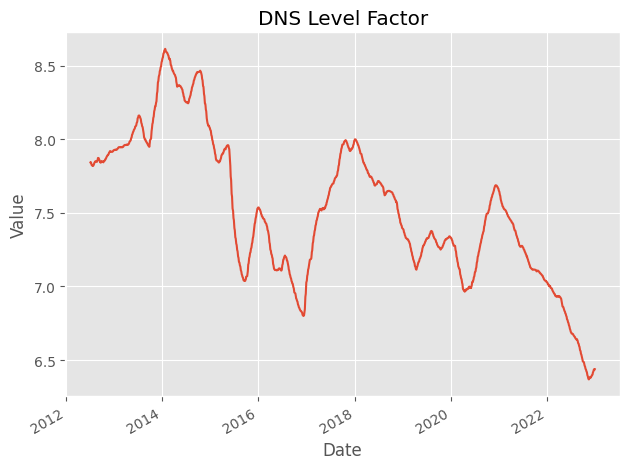

In [12]:
fig, ax = plt.subplots()

ax.plot(target['Date'], level_fator, label="Level")
ax.set_xlabel('Date')
ax.set_ylabel('Value')

plt.title("DNS Level Factor")
fig.autofmt_xdate()
plt.tight_layout()

In [13]:
level_fuller_result = adfuller(level_fator)

print(f'ADF Statistic: {level_fuller_result[0]}')
print(f'p-value: {level_fuller_result[1]}')

ADF Statistic: -1.5706011307377448
p-value: 0.4983425474712138


### 水平因子是非平稳的

In [14]:
level_diff = level_fator.diff()

level_diff_fuller_result = adfuller(level_diff[1:])

print(f'ADF Statistic: {level_diff_fuller_result[0]}')
print(f'p-value: {level_diff_fuller_result[1]}')

ADF Statistic: -6.443833695250109
p-value: 1.5838147442252038e-08


## 序列差是平稳的，所以水平因子的d = 1(一阶差分)

### 斜率因子平稳性分析

In [15]:
slope_fator = target['Slope']
slope_fator

0      -6.055007
1      -6.165470
2      -6.127162
3      -6.125234
4      -6.142828
          ...   
2614   -4.513261
2615   -4.473574
2616   -4.462218
2617   -4.498705
2618   -4.523375
Name: Slope, Length: 2619, dtype: float64

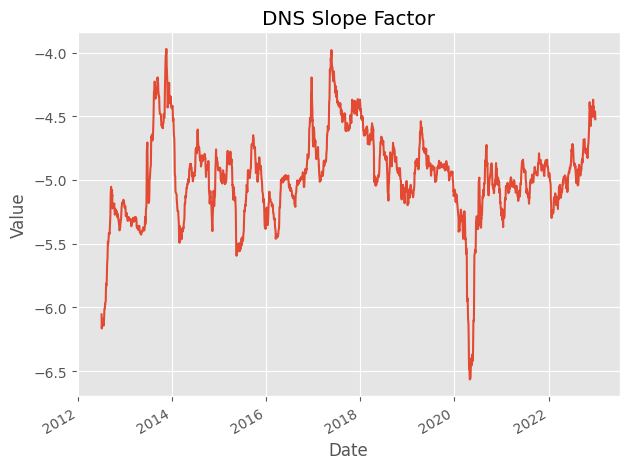

In [16]:
fig, ax = plt.subplots()

ax.plot(target['Date'], slope_fator, label="Slope")
ax.set_xlabel('Date')
ax.set_ylabel('Value')

plt.title("DNS Slope Factor")
fig.autofmt_xdate()
plt.tight_layout()

In [17]:
slope_fuller_result = adfuller(slope_fator)

print(f'ADF Statistic: {slope_fuller_result[0]}')
print(f'p-value: {slope_fuller_result[1]}')

ADF Statistic: -4.573940664216817
p-value: 0.00014423488317697616


### 斜率因子是平稳的，所以斜率因子的d = 0（不做差分）

### 曲率因子

In [18]:
curvature_fator = target['Curvature']
curvature_fator

0      -1.297614
1      -1.297116
2      -1.329055
3      -1.379119
4      -1.393478
          ...   
2614   -0.991240
2615   -1.001645
2616   -1.000916
2617   -0.991197
2618   -0.977861
Name: Curvature, Length: 2619, dtype: float64

In [19]:
curvature_fuller_result = adfuller(curvature_fator)

print(f'ADF Statistic: {curvature_fuller_result[0]}')
print(f'p-value: {curvature_fuller_result[1]}')

ADF Statistic: -4.333253763612562
p-value: 0.00038885990439373945


### 曲率因子是平稳的，所以斜率因子的d = 0（不做差分）

## 建模

### 水平因子建模

In [20]:
from typing import Union

def optimize_ARIMA(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm.tqdm(order_list):
        try: 
            # 
            model = SARIMAX(endog, exog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [21]:
level_ps = range(0, 4, 1)
level_qs = range(0, 4, 1)

level_order_list = list(product(level_ps, level_qs))
print(level_order_list)

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]


In [22]:
# 训练集: 测试集 = 8：2
# 训练集：验证集：测试集 = 6:2:2
data_ratio = 0.8
N = target.shape[0]
length = int(data_ratio * N)
target_train = target[:length]
exog_train = exog[:length]

target_test = target[length:]
exog_test = exog[length:]

select_train_columns_list = exog_train.columns.tolist()[2:]
exog_train = exog_train[select_train_columns_list]
exog_train = exog_train.astype(float)
exog_train

,CN_GDP_Current_Price_Cum_YTY,CN_GDP_Constant_Price_Cum_YTY,CN_GDP_Deflator_GDP_Cum_YTY,CN_GDP_Constant_Current_Q,CN_IFA_Cum_MTM,CN_IE_FGI_MTM,CN_PMI_New_Order,CN_PMI_RMP,CN_TRSCG_Cum_MOM,CN_PFE_MOM,...,LIBORO/N,LIBOR1W,LIBOR1M,LIBOR2M,LIBOR3M,LIBOR6M,LIBOR12M,CN_New_Jobs_Cum,CN_Difficulty_Cum,CN_Reemployed_Cum
0,18.49,9.550832,8.0272,127039.6,23.8,20.78,49.8,47.1,18.5,11.080000,...,0.15000,0.20720,0.29530,0.42820,0.58250,0.81100,1.13035,1221.0,0.0,0.0
1,18.49,9.550832,8.0272,127039.6,23.8,20.78,49.8,47.1,18.5,11.080000,...,0.14950,0.20620,0.29530,0.42920,0.58250,0.81200,1.13035,1221.0,0.0,0.0
2,18.49,9.550832,8.0272,127039.6,23.8,20.78,49.8,47.1,18.5,11.080000,...,0.14900,0.20620,0.29630,0.42820,0.58150,0.81200,1.13035,1221.0,0.0,0.0
3,18.49,9.550832,8.0272,127039.6,23.8,20.78,49.8,47.1,18.5,11.080000,...,0.14900,0.20620,0.29630,0.42820,0.58050,0.81000,1.12825,1221.0,0.0,0.0
4,18.49,9.550832,8.0272,127039.6,23.8,20.78,49.8,47.1,18.5,11.080000,...,0.15000,0.20420,0.29580,0.42820,0.57950,0.80850,1.12605,1221.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2090,-3.25,-6.900000,1.0976,183177.8,-10.3,10.60,50.2,42.5,-16.2,7.477403,...,0.06075,0.09200,0.17375,0.28163,0.36925,0.57000,0.68175,354.0,41.0,123.0
2091,-3.25,-6.900000,1.0976,183177.8,-10.3,10.60,50.2,42.5,-16.2,7.477403,...,0.06075,0.09200,0.17375,0.28163,0.36925,0.57000,0.68175,354.0,41.0,123.0
2092,-3.25,-6.900000,1.0976,183177.8,-10.3,10.60,50.2,42.5,-16.2,7.477403,...,0.06025,0.09488,0.16950,0.28525,0.37125,0.57163,0.67975,354.0,41.0,123.0
2093,-3.25,-6.900000,1.0976,183177.8,-10.3,10.60,50.2,42.5,-16.2,7.477403,...,0.06163,0.08825,0.17363,0.28875,0.36250,0.54838,0.68050,354.0,41.0,123.0


In [23]:
level_target_train = target_train['Level']
level_target_test = target_test['Level']


In [24]:
# 参数优化，确定p,q值。需要一定的时间
# 注意d=1
level_result_df = optimize_ARIMA(level_target_train, exog_train, level_order_list, d=1)
level_result_df

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [07:13<00:00, 27.12s/it]


,"(p,q)",AIC
0,"(1, 1)",-18996.708841
1,"(1, 2)",-18995.764104
2,"(1, 3)",-18995.627384
3,"(3, 0)",-18995.414785
4,"(2, 1)",-18994.705085
5,"(2, 2)",-18994.095182
6,"(2, 3)",-18993.686020
7,"(3, 2)",-18993.636955
8,"(3, 3)",-18991.647142
9,"(3, 1)",-18990.004184


In [25]:
# SARIMAX(3,1,3)
# SARIMA(p,d,q)
# 	(p,q)	AIC
# 0	(0, 1)	-26591.761733
level_p = 1
level_q = 1
level_d = 1

level_best_model = SARIMAX(level_target_train, exog_train, order=(level_p,level_d,level_q), simple_differencing=False)
level_best_model_fit = level_best_model.fit(disp=False)

print(level_best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Level   No. Observations:                 2095
Model:               SARIMAX(1, 1, 1)   Log Likelihood                9683.354
Date:                Tue, 21 Mar 2023   AIC                         -18996.709
Time:                        19:14:13   BIC                         -17952.045
Sample:                             0   HQIC                        -18614.021
                               - 2095                                         
Covariance Type:                  opg                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
CN_GDP_Current_Price_Cum_YTY     -0.0011   9.69e-05    -11.320      0.000      -0.001      -0.001
CN_GDP_Constant_Price_Cum_YTY     0.0018   8.51e-05     21.428      0.000 

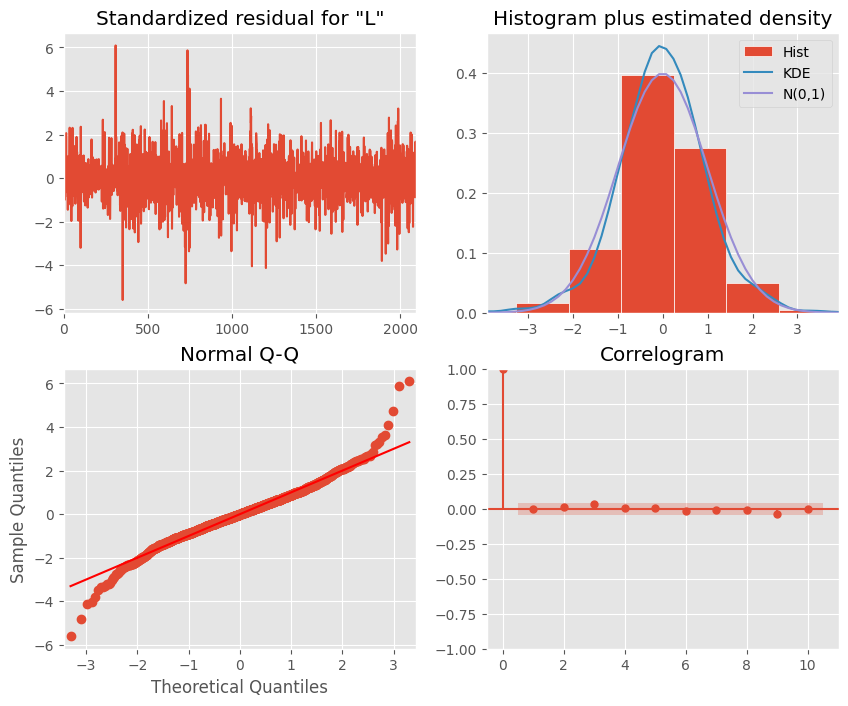

In [26]:
level_best_model_fit.plot_diagnostics(figsize=(10,8));

In [27]:
residuals = level_best_model_fit.resid

acorr_ljungbox(residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,0.000032,0.995473
2,0.000287,0.999856
3,0.000292,0.999999
4,0.000293,1.000000
5,0.000333,1.000000
6,0.000336,1.000000
7,0.000418,1.000000
8,0.000439,1.000000
9,0.000467,1.000000
10,0.000472,1.000000


In [28]:
def recursive_forecast(endog: Union[pd.Series, list], exog: Union[pd.Series, list], 
                       train_len: int, horizon: int, window: int, p: int,q: int, d: int) -> list:
    
    total_len = train_len + horizon
    
    pred_ARMA = []
    
    for i in range(train_len, total_len, window):
        print(i, total_len)
        model = SARIMAX(endog[:i], exog[:i], order=(p,d,q), simple_differencing=False)
        res = model.fit(disp=False)
        predictions = res.get_prediction(exog=exog)
        oos_pred = predictions.predicted_mean.iloc[-window:]
        pred_ARMA.extend(oos_pred)
        
    return pred_ARMA

In [29]:

level_pred_df = pd.DataFrame({'actual': level_target_test})

TRAIN_LEN = len(level_target_train)
HORIZON = len(level_target_test)
WINDOW = 1


level_pred_ARMA = recursive_forecast(target['Level'], exog[select_train_columns_list], TRAIN_LEN, HORIZON, WINDOW, p=level_p, q=level_q, d = level_d)

level_pred_df['pred_ARMA'] = level_pred_ARMA

level_pred_df

2095 2619
2096 2619
2097 2619
2098 2619
2099 2619
2100 2619
2101 2619
2102 2619
2103 2619
2104 2619
2105 2619
2106 2619
2107 2619
2108 2619
2109 2619
2110 2619
2111 2619
2112 2619
2113 2619
2114 2619
2115 2619
2116 2619
2117 2619
2118 2619
2119 2619
2120 2619
2121 2619
2122 2619
2123 2619
2124 2619
2125 2619
2126 2619
2127 2619
2128 2619
2129 2619
2130 2619
2131 2619
2132 2619
2133 2619
2134 2619
2135 2619
2136 2619
2137 2619
2138 2619
2139 2619
2140 2619
2141 2619
2142 2619
2143 2619
2144 2619
2145 2619
2146 2619
2147 2619
2148 2619
2149 2619
2150 2619
2151 2619
2152 2619
2153 2619
2154 2619
2155 2619
2156 2619
2157 2619
2158 2619
2159 2619
2160 2619
2161 2619
2162 2619
2163 2619
2164 2619
2165 2619
2166 2619
2167 2619
2168 2619
2169 2619
2170 2619
2171 2619
2172 2619
2173 2619
2174 2619
2175 2619
2176 2619
2177 2619
2178 2619
2179 2619
2180 2619
2181 2619
2182 2619
2183 2619
2184 2619
2185 2619
2186 2619
2187 2619
2188 2619
2189 2619
2190 2619
2191 2619
2192 2619
2193 2619
2194 2619


,actual,pred_ARMA
2095,7.667266,7.664821
2096,7.674452,7.666328
2097,7.677864,7.674051
2098,7.679479,7.681281
2099,7.682141,7.678588
...,...,...
2614,6.438232,6.434979
2615,6.437766,6.438900
2616,6.437606,6.439305
2617,6.438723,6.443845


## 斜率因子(Slope)

In [30]:
# 斜率因子 Slope
slope_target_train = target_train['Slope']
slope_target_test = target_test['Slope']

In [31]:
slope_ps = range(0, 4, 1)
slope_qs = range(0, 4, 1)

slope_order_list = list(product(slope_ps, slope_qs))
print(level_order_list)

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]


In [32]:
# 参数优化，确定p,q值。需要一定的时间
# 注意d = 0
slope_result_df = optimize_ARIMA(slope_target_train, exog_train, slope_order_list, d=0)
slope_result_df

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [06:26<00:00, 24.14s/it]


,"(p,q)",AIC
0,"(2, 2)",-4516.651476
1,"(1, 3)",-4516.174861
2,"(2, 3)",-4515.625306
3,"(2, 0)",-4515.522136
4,"(1, 1)",-4515.221687
5,"(3, 2)",-4514.508375
6,"(1, 2)",-4514.505947
7,"(3, 0)",-4514.096557
8,"(3, 3)",-4514.001984
9,"(2, 1)",-4513.209496


In [33]:
#模型训练
# SARIMAX(3,1,3)
# SARIMA(p,d,q)
# 	(p,q)	AIC
# 0	(0, 1)	-26591.761733
slope_p = 2
slope_q = 2
slope_d = 0

slope_best_model = SARIMAX(slope_target_train, exog_train, order=(slope_p,slope_d,slope_q), simple_differencing=False)
slope_best_model_fit = slope_best_model.fit(disp=False)

print(slope_best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Slope   No. Observations:                 2095
Model:               SARIMAX(2, 0, 2)   Log Likelihood                2445.326
Date:                Tue, 21 Mar 2023   AIC                          -4516.651
Time:                        23:10:20   BIC                          -3460.605
Sample:                             0   HQIC                         -4129.803
                               - 2095                                         
Covariance Type:                  opg                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
CN_GDP_Current_Price_Cum_YTY      0.0155      0.002      9.098      0.000       0.012       0.019
CN_GDP_Constant_Price_Cum_YTY    -0.0731        nan        nan        nan 

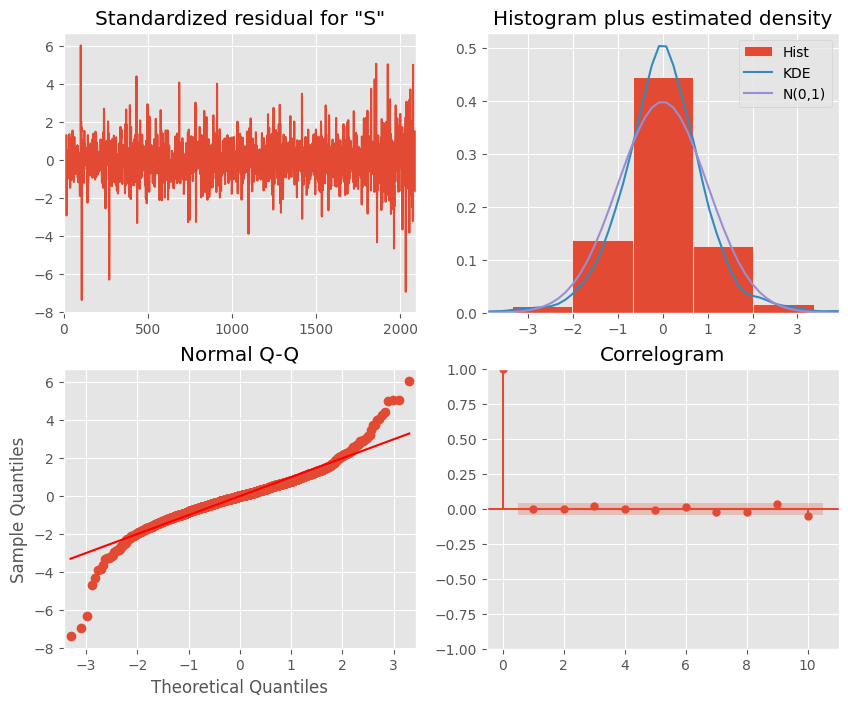

In [34]:
slope_best_model_fit.plot_diagnostics(figsize=(10,8));

In [35]:
# 获取预测值


slope_pred_df = pd.DataFrame({'actual': slope_target_test})

TRAIN_LEN = len(slope_target_train)
HORIZON = len(slope_target_test)
WINDOW = 1


slope_pred_ARMA = recursive_forecast(target['Slope'], exog[select_train_columns_list], TRAIN_LEN, HORIZON, WINDOW, p=slope_p, q=slope_q, d = slope_d)

slope_pred_df['pred_ARMA'] = slope_pred_ARMA

slope_pred_df

2095 2619
2096 2619
2097 2619
2098 2619
2099 2619
2100 2619
2101 2619
2102 2619
2103 2619
2104 2619
2105 2619
2106 2619
2107 2619
2108 2619
2109 2619
2110 2619
2111 2619
2112 2619
2113 2619
2114 2619
2115 2619
2116 2619
2117 2619
2118 2619
2119 2619
2120 2619
2121 2619
2122 2619
2123 2619
2124 2619
2125 2619
2126 2619
2127 2619
2128 2619
2129 2619
2130 2619
2131 2619
2132 2619
2133 2619
2134 2619
2135 2619
2136 2619
2137 2619
2138 2619
2139 2619
2140 2619
2141 2619
2142 2619
2143 2619
2144 2619
2145 2619
2146 2619
2147 2619
2148 2619
2149 2619
2150 2619
2151 2619
2152 2619
2153 2619
2154 2619
2155 2619
2156 2619
2157 2619
2158 2619
2159 2619
2160 2619
2161 2619
2162 2619
2163 2619
2164 2619
2165 2619
2166 2619
2167 2619
2168 2619
2169 2619
2170 2619
2171 2619
2172 2619
2173 2619
2174 2619
2175 2619
2176 2619
2177 2619
2178 2619
2179 2619
2180 2619
2181 2619
2182 2619
2183 2619
2184 2619
2185 2619
2186 2619
2187 2619
2188 2619
2189 2619
2190 2619
2191 2619
2192 2619
2193 2619
2194 2619


,actual,pred_ARMA
2095,-4.944337,-4.814227
2096,-5.033804,-4.822744
2097,-5.036227,-5.333871
2098,-4.995420,-5.029219
2099,-4.979254,-4.893273
...,...,...
2614,-4.513261,-4.418907
2615,-4.473574,-4.457372
2616,-4.462218,-4.477579
2617,-4.498705,-4.625413


## 曲率因子(Curvature)

In [36]:
# 曲率因子 curvature
curvature_target_train = target_train['Curvature']
curvature_target_test = target_test['Curvature']



In [37]:
curvature_ps = range(0, 4, 1)
curvature_qs = range(0, 4, 1)

curvature_order_list = list(product(curvature_ps, curvature_qs))
print(curvature_order_list)

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]


In [38]:
# 参数优化，确定p,q值。需要一定的时间
curvature_result_df = optimize_ARIMA(curvature_target_train, exog_train, curvature_order_list, d=0)
curvature_result_df

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [06:24<00:00, 24.01s/it]


,"(p,q)",AIC
0,"(2, 2)",-2308.568199
1,"(2, 0)",-2307.766960
2,"(3, 2)",-2306.563539
3,"(2, 1)",-2306.134556
4,"(1, 1)",-2306.124672
5,"(3, 0)",-2305.995403
6,"(1, 3)",-2305.175742
7,"(1, 2)",-2304.937606
8,"(3, 1)",-2304.440726
9,"(2, 3)",-2304.097523


In [39]:
#模型训练
# SARIMAX(3,1,3)
# SARIMA(p,d,q)
# 	(p,q)	AIC
# 0	(0, 1)	-26591.761733
curvature_p = 2
curvature_q = 2
curvature_d = 0

curvature_best_model = SARIMAX(curvature_target_train, exog_train, order=(curvature_p,curvature_d,curvature_q), simple_differencing=False)
curvature_best_model_fit = curvature_best_model.fit(disp=False)

print(curvature_best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Curvature   No. Observations:                 2095
Model:               SARIMAX(2, 0, 2)   Log Likelihood                1341.284
Date:                Wed, 22 Mar 2023   AIC                          -2308.568
Time:                        03:31:39   BIC                          -1252.521
Sample:                             0   HQIC                         -1921.720
                               - 2095                                         
Covariance Type:                  opg                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
CN_GDP_Current_Price_Cum_YTY      0.0362      0.003     11.624      0.000       0.030       0.042
CN_GDP_Constant_Price_Cum_YTY    -0.3355      0.001   -279.580      0.000 

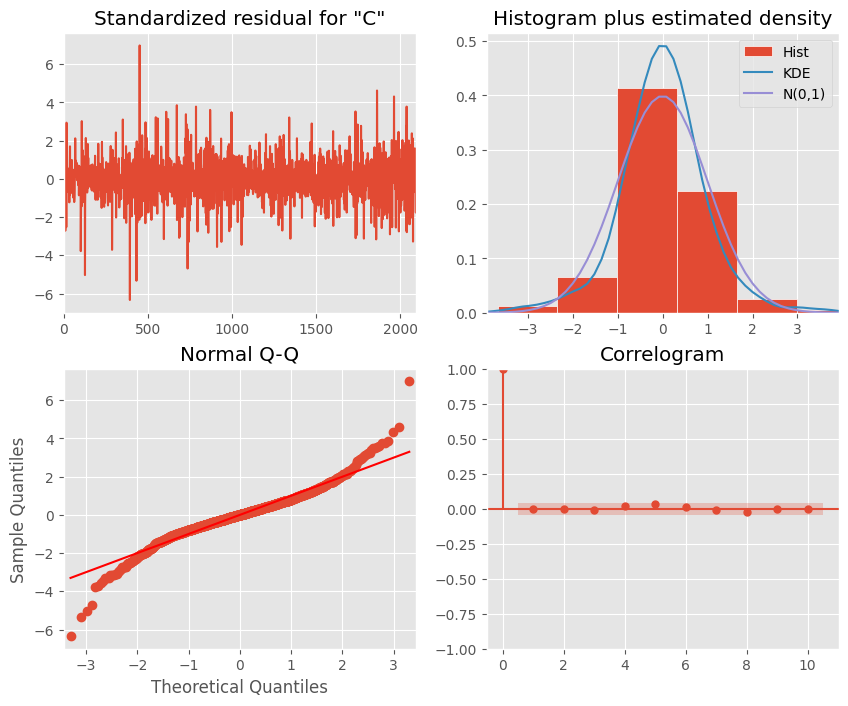

In [40]:
curvature_best_model_fit.plot_diagnostics(figsize=(10,8));

In [41]:
# 获取预测值


curvature_pred_df = pd.DataFrame({'actual': curvature_target_test})

TRAIN_LEN = len(curvature_target_train)
HORIZON = len(curvature_target_test)
WINDOW = 1


curvature_pred_ARMA = recursive_forecast(target['Curvature'], exog[select_train_columns_list], TRAIN_LEN, HORIZON, WINDOW, 
                                         p=curvature_p, q=curvature_q, d = curvature_d)



2095 2619
2096 2619
2097 2619
2098 2619
2099 2619
2100 2619
2101 2619
2102 2619
2103 2619
2104 2619
2105 2619
2106 2619
2107 2619
2108 2619
2109 2619
2110 2619
2111 2619
2112 2619
2113 2619
2114 2619
2115 2619
2116 2619
2117 2619
2118 2619
2119 2619
2120 2619
2121 2619
2122 2619
2123 2619
2124 2619
2125 2619
2126 2619
2127 2619
2128 2619
2129 2619
2130 2619
2131 2619
2132 2619
2133 2619
2134 2619
2135 2619
2136 2619
2137 2619
2138 2619
2139 2619
2140 2619
2141 2619
2142 2619
2143 2619
2144 2619
2145 2619
2146 2619
2147 2619
2148 2619
2149 2619
2150 2619
2151 2619
2152 2619
2153 2619
2154 2619
2155 2619
2156 2619
2157 2619
2158 2619
2159 2619
2160 2619
2161 2619
2162 2619
2163 2619
2164 2619
2165 2619
2166 2619
2167 2619
2168 2619
2169 2619
2170 2619
2171 2619
2172 2619
2173 2619
2174 2619
2175 2619
2176 2619
2177 2619
2178 2619
2179 2619
2180 2619
2181 2619
2182 2619
2183 2619
2184 2619
2185 2619
2186 2619
2187 2619
2188 2619
2189 2619
2190 2619
2191 2619
2192 2619
2193 2619
2194 2619


In [42]:
curvature_pred_df['pred_ARMA'] = curvature_pred_ARMA

curvature_pred_df

,actual,pred_ARMA
2095,-2.720878,-2.710002
2096,-2.718138,-2.926915
2097,-2.720984,-2.724482
2098,-2.732786,-2.835950
2099,-2.747765,-2.559027
...,...,...
2614,-0.991240,-0.924712
2615,-1.001645,-0.983503
2616,-1.000916,-0.868097
2617,-0.991197,-1.450197


In [43]:
# 保存数据
all_pred_df = pd.DataFrame()
all_pred_df['Date'] = target_test['Date']
all_pred_df['Level'] = level_pred_ARMA
all_pred_df['Slope'] = slope_pred_ARMA
all_pred_df['Curvature'] = curvature_pred_ARMA

all_pred_df.to_csv("./data/Pred_AFNS_Factor_6M.csv", index=False, encoding="utf-8-sig")

In [44]:
all_pred_df

,Date,Level,Slope,Curvature
2095,2020-11-27,7.664821,-4.814227,-2.710002
2096,2020-11-30,7.666328,-4.822744,-2.926915
2097,2020-12-01,7.674051,-5.333871,-2.724482
2098,2020-12-02,7.681281,-5.029219,-2.835950
2099,2020-12-03,7.678588,-4.893273,-2.559027
...,...,...,...,...
2614,2022-12-26,6.434979,-4.418907,-0.924712
2615,2022-12-27,6.438900,-4.457372,-0.983503
2616,2022-12-28,6.439305,-4.477579,-0.868097
2617,2022-12-29,6.443845,-4.625413,-1.450197
